# 3b
## Brain Tumor Detection
## Using CNNs as Feature Extractors  

In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

import cv2
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

#### Helper functions to change and use different device

In [2]:
#### Helper functions to change and use different device# Helper functions to load data into gpu if available
#Pick GPU if available, else CPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

### Data Loading

In [3]:
### Data Loadingtransform = Compose([
        ToTensor(),
        transforms.Resize((256,256)),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 4
val_size = 200


dataset = torchvision.datasets.ImageFolder(root='./tumor2/Training/',transform=transform)

train_size = len(dataset) - val_size

trainset, valset = random_split(dataset, [train_size, val_size])

dataset = torchvision.datasets.ImageFolder(root='./tumor2/Training/',transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=8, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=8, pin_memory=True)

test_dataset = torchvision.datasets.ImageFolder(root='./tumor2/Testing/',transform=transform)
testloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=8, pin_memory = True)

classes = ['glioma','meningiom','no','pituitary']

#### Showing few images in the loaded data

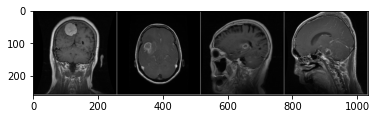

meningiom glioma  glioma  glioma 


In [7]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:7s}' for j in range(batch_size)))

## Extract Features from AlexNet

In [13]:
alexnet2 = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet2.eval()

Using cache found in /home/dhamodhar/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
def get_features(dataloader):
    X = np.array([]) 
    y = np.array([])
    with torch.no_grad():                                                                     
        for data in dataloader:    
            images, labels = data
            inp = torch.tensor(images)                                
            output = alexnet2(inp)     
            if X.size ==0:
                X = output
            else:
                X = np.vstack((X,output))
            y = np.append(y, labels)
        return X,y

### Loading features from AlexNet for Train and Test

In [15]:
X_train,y_train = get_features(trainloader) 
X_test,y_test = get_features(testloader) 

/tmp/ipykernel_8980/1917036562.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(images)


### Logistics Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [18]:
logreg=LogisticRegression(max_iter = 10000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

In [20]:
pred = logreg.predict(X_test)

In [33]:
print('Confusion Matrix :\n\n' + str(confusion_matrix(y_test,pred)))
print()
print('Classification Report :\n\n' + str(classification_report(y_test,pred)))

Confusion Matrix :

[[ 22  48  26   4]
 [  1 111   3   0]
 [  0   0 105   0]
 [  2  13   2  57]]

Classification Report :

              precision    recall  f1-score   support

         0.0       0.88      0.22      0.35       100
         1.0       0.65      0.97      0.77       115
         2.0       0.77      1.00      0.87       105
         3.0       0.93      0.77      0.84        74

    accuracy                           0.75       394
   macro avg       0.81      0.74      0.71       394
weighted avg       0.79      0.75      0.71       394



### SVM

In [22]:
from sklearn.svm import SVC

In [24]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.290 total time=   4.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.292 total time=   4.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.292 total time=   4.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.290 total time=   4.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.290 total time=   4.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.290 total time=   4.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.292 total time=   4.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.292 total time=   4.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.290 total time=   4.8s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.290 total time=   4.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.290 total time=   4.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=3)

In [25]:
pred2 =grid.predict(X_test)

In [34]:
print('Confusion Matrix :\n\n' + str(confusion_matrix(y_test,pred2)))
print()
print('Classification Report :\n\n' + str(classification_report(y_test,pred2)))

Confusion Matrix :

[[ 28  43  28   1]
 [  1 113   1   0]
 [  0   0 105   0]
 [  0  12   7  55]]

Classification Report :

              precision    recall  f1-score   support

         0.0       0.97      0.28      0.43       100
         1.0       0.67      0.98      0.80       115
         2.0       0.74      1.00      0.85       105
         3.0       0.98      0.74      0.85        74

    accuracy                           0.76       394
   macro avg       0.84      0.75      0.73       394
weighted avg       0.82      0.76      0.73       394



### Softmax on Last Layer

In [4]:
device = get_default_device()

In [5]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr,momentum):
    history = []
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [6]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()

In [7]:
class BaseNet(nn.Module):
    def __init__(self):
        super().__init__()
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))


In [8]:
class AlexNet(BaseNet):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 11, stride=4, padding=0 )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=1000)
        self.fc4 = nn.Linear(in_features=1000 , out_features=4)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x))
        return x

In [9]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
alexnet_custom = AlexNet()
alexnet_custom.to(torch.device('cuda'))
begin = time.time()
history, end = fit(30,alexnet_custom, trainloader, valloader, lr = 0.001, momentum=0.9)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|█████████████████████████████████████████| 668/668 [00:44<00:00, 14.88it/s]


Epoch [0], Time taken :47.7252, train_loss : 1.3608, train_acc: 0.2930, val_loss: 1.3470, val_acc: 0.2500


100%|█████████████████████████████████████████| 668/668 [00:43<00:00, 15.27it/s]


Epoch [1], Time taken :44.7942, train_loss : 1.3500, train_acc: 0.2871, val_loss: 1.3400, val_acc: 0.2500


100%|█████████████████████████████████████████| 668/668 [00:46<00:00, 14.23it/s]


Epoch [2], Time taken :48.1354, train_loss : 1.3466, train_acc: 0.3024, val_loss: 1.3360, val_acc: 0.2500


100%|█████████████████████████████████████████| 668/668 [00:48<00:00, 13.76it/s]


Epoch [3], Time taken :49.8557, train_loss : 1.2557, train_acc: 0.3724, val_loss: 1.2071, val_acc: 0.3950


100%|█████████████████████████████████████████| 668/668 [00:50<00:00, 13.32it/s]


Epoch [4], Time taken :51.3748, train_loss : 1.1100, train_acc: 0.5090, val_loss: 1.1047, val_acc: 0.5550


100%|█████████████████████████████████████████| 668/668 [00:51<00:00, 13.10it/s]


Epoch [5], Time taken :52.3477, train_loss : 0.8743, train_acc: 0.6213, val_loss: 0.8048, val_acc: 0.6700


100%|█████████████████████████████████████████| 668/668 [00:50<00:00, 13.19it/s]


Epoch [6], Time taken :52.1430, train_loss : 0.7879, train_acc: 0.6707, val_loss: 0.8709, val_acc: 0.6700


100%|█████████████████████████████████████████| 668/668 [00:55<00:00, 12.03it/s]


Epoch [7], Time taken :56.9198, train_loss : 0.6941, train_acc: 0.7197, val_loss: 0.7140, val_acc: 0.6900


100%|█████████████████████████████████████████| 668/668 [00:54<00:00, 12.26it/s]


Epoch [8], Time taken :56.0928, train_loss : 0.6250, train_acc: 0.7406, val_loss: 0.7307, val_acc: 0.6700


100%|█████████████████████████████████████████| 668/668 [00:54<00:00, 12.16it/s]


Epoch [9], Time taken :56.6399, train_loss : 0.5505, train_acc: 0.7698, val_loss: 0.5548, val_acc: 0.7300


100%|█████████████████████████████████████████| 668/668 [00:55<00:00, 11.93it/s]


Epoch [10], Time taken :57.7341, train_loss : 0.4833, train_acc: 0.8159, val_loss: 0.6227, val_acc: 0.6750


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.70it/s]


Epoch [11], Time taken :63.7518, train_loss : 0.4242, train_acc: 0.8372, val_loss: 0.5293, val_acc: 0.7800


100%|█████████████████████████████████████████| 668/668 [00:58<00:00, 11.43it/s]


Epoch [12], Time taken :60.5534, train_loss : 0.3476, train_acc: 0.8645, val_loss: 0.6379, val_acc: 0.7300


100%|█████████████████████████████████████████| 668/668 [01:01<00:00, 10.78it/s]


Epoch [13], Time taken :64.3055, train_loss : 0.3043, train_acc: 0.8855, val_loss: 0.3294, val_acc: 0.8400


100%|█████████████████████████████████████████| 668/668 [01:03<00:00, 10.48it/s]


Epoch [14], Time taken :65.2028, train_loss : 0.2847, train_acc: 0.8888, val_loss: 0.3086, val_acc: 0.8600


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.74it/s]


Epoch [15], Time taken :64.1877, train_loss : 0.2125, train_acc: 0.9207, val_loss: 0.3992, val_acc: 0.8400


100%|█████████████████████████████████████████| 668/668 [01:05<00:00, 10.19it/s]


Epoch [16], Time taken :67.5364, train_loss : 0.2052, train_acc: 0.9225, val_loss: 0.5871, val_acc: 0.7700


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.64it/s]


Epoch [17], Time taken :65.1868, train_loss : 0.1715, train_acc: 0.9323, val_loss: 0.4253, val_acc: 0.8450


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.69it/s]


Epoch [18], Time taken :64.5434, train_loss : 0.1411, train_acc: 0.9484, val_loss: 0.2983, val_acc: 0.8700


100%|█████████████████████████████████████████| 668/668 [01:00<00:00, 11.13it/s]


Epoch [19], Time taken :62.0588, train_loss : 0.1362, train_acc: 0.9506, val_loss: 0.3222, val_acc: 0.8700


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.66it/s]


Epoch [20], Time taken :64.6089, train_loss : 0.1364, train_acc: 0.9566, val_loss: 0.3574, val_acc: 0.8700


100%|█████████████████████████████████████████| 668/668 [01:00<00:00, 11.03it/s]


Epoch [21], Time taken :62.8910, train_loss : 0.0836, train_acc: 0.9648, val_loss: 0.4529, val_acc: 0.8750


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.64it/s]


Epoch [22], Time taken :65.0550, train_loss : 0.0499, train_acc: 0.9858, val_loss: 0.5585, val_acc: 0.8550


100%|█████████████████████████████████████████| 668/668 [01:03<00:00, 10.49it/s]


Epoch [23], Time taken :65.0740, train_loss : 0.0962, train_acc: 0.9697, val_loss: 0.5364, val_acc: 0.8450


100%|█████████████████████████████████████████| 668/668 [01:02<00:00, 10.70it/s]


Epoch [24], Time taken :64.6333, train_loss : 0.0434, train_acc: 0.9820, val_loss: 0.9552, val_acc: 0.8250


100%|█████████████████████████████████████████| 668/668 [01:04<00:00, 10.35it/s]


Epoch [25], Time taken :66.9048, train_loss : 0.0572, train_acc: 0.9802, val_loss: 0.3074, val_acc: 0.9000


100%|█████████████████████████████████████████| 668/668 [01:04<00:00, 10.32it/s]


Epoch [26], Time taken :66.6484, train_loss : 0.0246, train_acc: 0.9903, val_loss: 0.6565, val_acc: 0.8450


100%|█████████████████████████████████████████| 668/668 [01:07<00:00,  9.83it/s]


Epoch [27], Time taken :70.0589, train_loss : 0.0669, train_acc: 0.9772, val_loss: 0.4617, val_acc: 0.8400


100%|█████████████████████████████████████████| 668/668 [01:09<00:00,  9.56it/s]


Epoch [28], Time taken :72.4841, train_loss : 0.0323, train_acc: 0.9888, val_loss: 0.4190, val_acc: 0.8850


100%|█████████████████████████████████████████| 668/668 [01:05<00:00, 10.16it/s]


Epoch [29], Time taken :68.0510, train_loss : 0.0330, train_acc: 0.9906, val_loss: 0.3480, val_acc: 0.9100
Finished Training in 1818.1557445526123secs


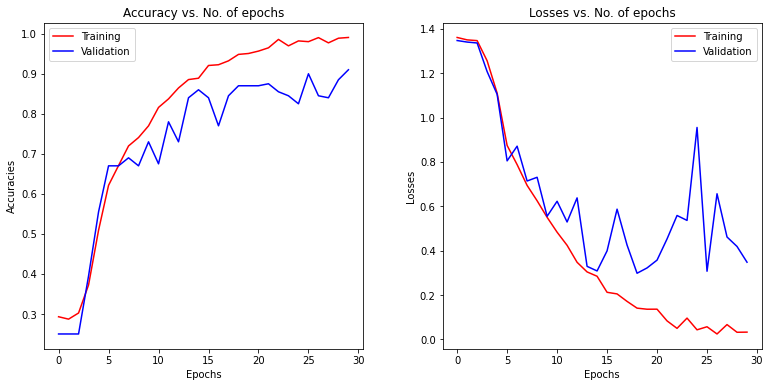

In [11]:
plot_results(history)

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = alexnet_custom(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 70 %
